# License
---
Copyright (c) 2018, Simon Brodeur<br>
All rights reserved.<br>

Redistribution and use in source and binary forms, with or without <br>
modification, are permitted provided that the following conditions are met:<br>

1. Redistributions of source code must retain the above copyright <br>
   notice, this list of conditions and the following disclaimer.<br>
<br>
2. Redistributions in binary form must reproduce the above copyright<br>
   notice, this list of conditions and the following disclaimer in the<br>
   documentation and/or other materials provided with the distribution.<br>
<br>
3. Neither the name of the copyright holder nor the names of its contributors<br>
   may be used to endorse or promote products derived from this software without<br>
   specific prior written permission.<br>

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND<br>
ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED <br>
WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE DISCLAIMED.<br>
IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, <br>
INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT <br>
NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR <br>
PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, <br>
WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) <br>
ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY <br>
OF SUCH DAMAGE.<br>

---

## Import required Python modules

In [1]:
%matplotlib inline

import os
import logging
import numpy as np
import cv2
import h5py

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Define class to handle HDF5 dataset files

In [2]:
class Hdf5CreateDataset:

    def __init__(self, filePath):
        self.h = h5py.File(filePath, mode='r')
        
    def getData(self, name, group=None):
        
        if group is not None:
            g = self.h[group]
        else:
            g = self.h
        g = g[name]
            
        assert 'data' in g.keys()
        data = np.array(g['data'])
        clock = np.array(g['clock'])
        if 'shape' in g.keys():
            shape = np.array(g['shape'])
        else:
            shape = None
            
        return [data, clock, shape]
            
    def close(self):
        self.h.close()

    def __enter__(self):
        return self

    def __exit__(self, type, value, tb):
        self.close()


# Load HDF5 Create dataset and visualize sensors
___

Please set the correct path to the Create HDF5 dataset with the variable below:

In [3]:
inputDatasetPath = '/home/simon/Data/Create'

In [4]:
inputHdf5File = os.path.join(inputDatasetPath, 'E3/C1-3036/E3_C13036_S1_20161222T101923.h5')
dataset = Hdf5CreateDataset(inputHdf5File)


Specify whether or not to save generated figures to disk

In [5]:
saveFigures = False

## Audio
___

Load left and right channel data

In [6]:
# NOTE: This is the known sampling frequency
fs = 16000

def getPerSampleClock(data, clock, fs):
    chunkSize = data.shape[1]
    sclock = []
    for t in clock:
        tc = t - np.arange(chunkSize)[::-1] / fs
        sclock.append(tc)
    sclock = np.array(sclock).ravel()
    return sclock

ldata, lclock, _ = dataset.getData('left', 'audio')
lclock = getPerSampleClock(ldata, lclock, fs)
ldata = np.array(ldata.flatten(), dtype=np.float32) / np.iinfo('int16').max

rdata, rclock, _ = dataset.getData('right', 'audio')
rclock = getPerSampleClock(rdata, rclock, fs)
rdata = np.array(rdata.flatten(), dtype=np.float32) / np.iinfo('int16').max

Plot left and right channel signals

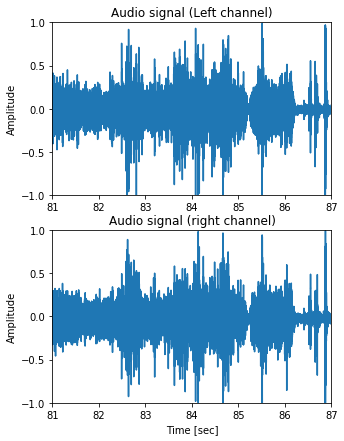

In [7]:
fig = plt.figure(figsize=(5,7), facecolor='white', frameon=False)

# NOTE: only show this small time interval
xlim = [81.0, 87.0]

# Left channel
plt.subplot(211)
plt.title('Audio signal (Left channel)')
plt.ylabel('Amplitude')

plt.plot(lclock, ldata)
ymax = np.max(np.abs(ldata))
plt.xlim(xlim)
plt.ylim([-ymax, ymax])

# Right channel
plt.subplot(212)
plt.title('Audio signal (right channel)')
plt.xlabel('Time [sec]')
plt.ylabel('Amplitude')

plt.plot(rclock, rdata)
ymax = np.max(np.abs(rdata))
plt.xlim(xlim)
plt.ylim([-ymax, ymax])

if saveFigures:
    fig.savefig('audio-signal.eps', dpi=300, bbox_inches='tight')

Plot left and right channel magnitude spectrograms

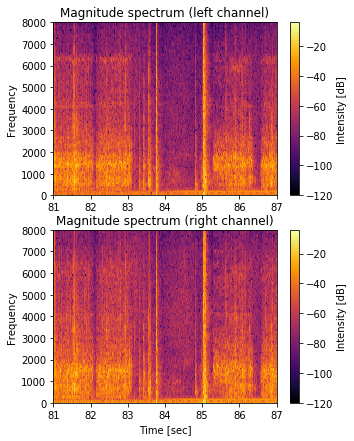

In [8]:
fig = plt.figure(figsize=(5,7), facecolor='white', frameon=False)

# NOTE: make sure left and right channels are approximately aligned in time, 
#       since the 'specgram' of Matplotlib doesn't allow to specify the times.
nbTrimSamples = int(np.abs(rclock[0] - lclock[0]) * fs)
if rclock[0] > lclock[0]:
    ldata = ldata[nbTrimSamples:]
else:
    rdata = rdata[nbTrimSamples:]

# NOTE: only show this small time interval
xlim = [81.0, 87.0]

# Left channel
plt.subplot(211)
vmin = 20*np.log10(np.max(ldata)) - 120
pxx, freq, t, cax = plt.specgram(ldata, NFFT=256, Fs=fs, noverlap=128, vmin=vmin, mode='magnitude', scale='dB', cmap='inferno')
fig.colorbar(cax).set_label('Intensity [dB]')
plt.xlim(xlim)
plt.title('Magnitude spectrum (left channel)')
plt.ylabel('Frequency')

# Right channel
plt.subplot(212)
vmin = 20*np.log10(np.max(ldata)) - 120
pxx, freq, t, cax = plt.specgram(rdata, NFFT=256, Fs=fs, noverlap=128, vmin=vmin, mode='magnitude', scale='dB', cmap='inferno')
fig.colorbar(cax).set_label('Intensity [dB]')
plt.xlim(xlim)
plt.title('Magnitude spectrum (right channel)')
plt.xlabel('Time [sec]')
plt.ylabel('Frequency')

if saveFigures:
    fig.savefig('audio-spectrogram.eps', dpi=300, bbox_inches='tight')

## Video
___
Using OpenCV to decode the JPEG images from a compressed data string

In [9]:
def decodeToRGB(data):
    # JPEG decoding using OpenCV
    img = cv2.imdecode(data, flags=1) # cv2.CV_LOAD_IMAGE_COLOR
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

Load left and right video data

In [10]:
ldata, lclock, lshape = dataset.getData('left', 'video')
rdata, rclock, rshape = dataset.getData('right', 'video')

Decode a single image for each camera

In [11]:
# NOTE: only show the frames at time 100.0 sec
frameTime = 100.0
lframeIndex = np.argmin(np.abs(lclock - frameTime))
rframeIndex = np.argmin(np.abs(rclock - frameTime))

imgLeft = decodeToRGB(ldata[lframeIndex,:lshape[lframeIndex,0]])
imgRight = decodeToRGB(rdata[rframeIndex,:rshape[rframeIndex,0]])

Plot left and right camera images

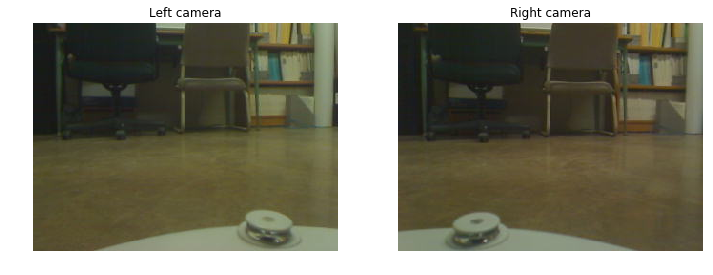

In [12]:
fig = plt.figure(figsize=(12,6), facecolor='white')
plt.tight_layout()

# Left camera
plt.subplot(121)
plt.imshow(imgLeft)
plt.axis('off')
plt.title('Left camera')

# Right camera
plt.subplot(122)
plt.imshow(imgRight)
plt.axis('off')
plt.title('Right camera')

if saveFigures:
    fig.savefig('camera-rgb.eps', dpi=300, bbox_inches='tight')

## Motors
___

Load left and right motor data

In [13]:
data, clock, _ = dataset.getData('linear_velocity', 'motor')
ldata = data[:,0] # Left motor
rdata = data[:,1] # Right motor

Plot left and right motor velocities

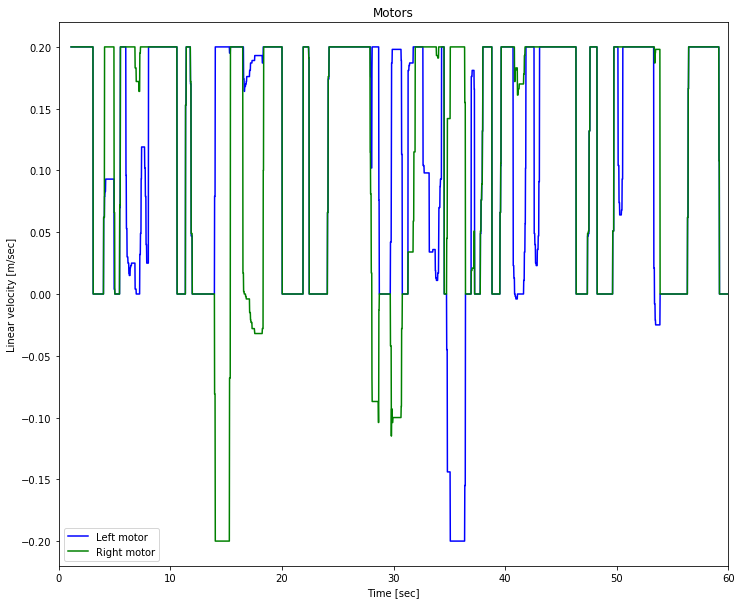

In [14]:
fig = plt.figure(figsize=(12,10), facecolor='white')

# NOTE: only show the first 60 seconds
xlim = [0, 60]

# Motors
plt.subplot(111)
plt.title('Motors')
plt.plot(clock, ldata, c='b', label='Left motor')
plt.plot(clock, rdata, c='g', label='Right motor')
plt.xlabel('Time [sec]')
plt.ylabel('Linear velocity [m/sec]')
plt.xlim(xlim)
plt.legend()

if saveFigures:
    fig.savefig('motor-linear-velocity.eps', dpi=300, bbox_inches='tight')

## Inertial Measurement Unit (IMU) : gyroscope, accelerometer and magnetometer
___

Load data and plot angular velocity data from IMU gyroscope

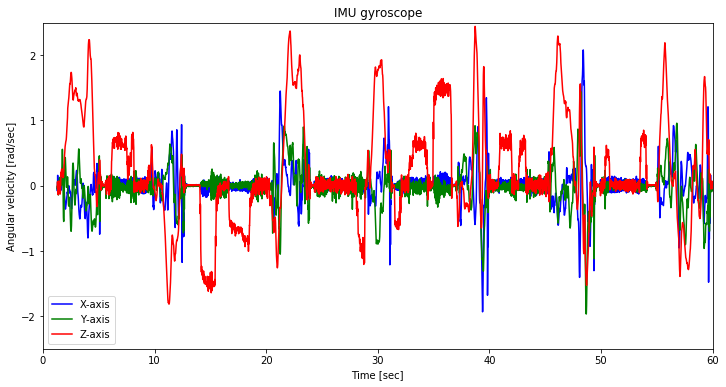

In [15]:
data, clock, _ = dataset.getData('angular_velocity', 'imu')
angularVelXData = data[:,0] # X-axis
angularVelYData = data[:,1] # Y-axis
angularVelZData = data[:,2] # Z-axis

fig = plt.figure(figsize=(12,6), facecolor='white')

# NOTE: only show the first 60 seconds
xlim = [0, 60]

plt.subplot(111)
plt.title('IMU gyroscope')
plt.plot(clock, angularVelXData, c='b', label='X-axis')
plt.plot(clock, angularVelYData, c='g', label='Y-axis')
plt.plot(clock, angularVelZData, c='r', label='Z-axis')
plt.xlabel('Time [sec]')
plt.ylabel('Angular velocity [rad/sec]')
plt.xlim(xlim)
plt.ylim([-2.5, 2.5])
plt.legend()

if saveFigures:
    fig.savefig('imu-angular-velocity.eps', dpi=300, bbox_inches='tight')

Load data and linear acceleration data from IMU accelerometer

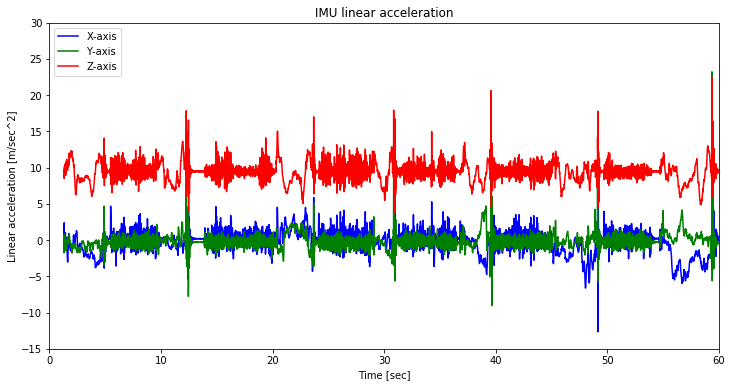

In [16]:
data, clock, _ = dataset.getData('linear_acceleration', 'imu')
linearAccelXData = data[:,0] # X-axis
linearAccelYData = data[:,1] # Y-axis
linearAccelZData = data[:,2] # Z-axis

fig = plt.figure(figsize=(12,6), facecolor='white')

# NOTE: only show the first 60 seconds
xlim = [0, 60]

plt.subplot(111)
plt.title('IMU linear acceleration')
plt.plot(clock, linearAccelXData, c='b', label='X-axis')
plt.plot(clock, linearAccelYData, c='g', label='Y-axis')
plt.plot(clock, linearAccelZData, c='r', label='Z-axis')
plt.xlabel('Time [sec]')
plt.ylabel('Linear acceleration [m/sec^2]')
plt.xlim(xlim)
plt.ylim([-15, 30])
plt.legend()

if saveFigures:
    fig.savefig('imu-linear-acceleration.eps', dpi=300, bbox_inches='tight')

Load data and plot magnetic field data from IMU magnetometer

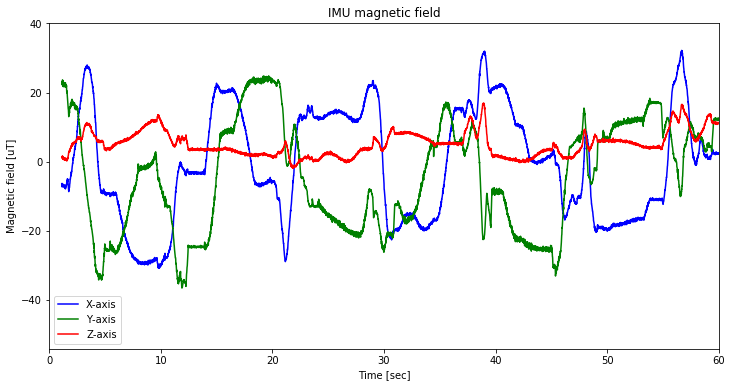

In [17]:
data, clock, _ = dataset.getData('magnetic_field', 'imu')

# Note: convert from T to uT
data = data * 1e6

magFieldXData = data[:,0] # X-axis
magFieldYData = data[:,1] # Y-axis
magFieldZData = data[:,2] # Z-axis

fig = plt.figure(figsize=(12,6), facecolor='white')

# NOTE: only show the first 60 seconds
xlim = [0, 60]

plt.subplot(111)
plt.title('IMU magnetic field')
plt.plot(clock, magFieldXData, c='b', label='X-axis')
plt.plot(clock, magFieldYData, c='g', label='Y-axis')
plt.plot(clock, magFieldZData, c='r', label='Z-axis')
plt.xlabel('Time [sec]')
plt.ylabel('Magnetic field [uT]')
plt.xlim(xlim)
plt.legend()

if saveFigures:
    fig.savefig('imu-magnetic-field.eps', dpi=300, bbox_inches='tight')

## Inertial Measurement Unit (IMU) : orientation
___

Define functions that will help plotting orientation in 3D

In [18]:
# Adapted from: http://stackoverflow.com/questions/22867620/putting-arrowheads-on-vectors-in-matplotlibs-3d-plot
class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def set_data(self, xs, ys, zs):
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)
        
# Adapted from: https://afni.nimh.nih.gov/pub/dist/src/pkundu/meica.libs/nibabel/quaternions.py
def quat2mat(q):
    w, x, y, z = q
    Nq = w*w + x*x + y*y + z*z
    if Nq < np.finfo(np.float64).eps:
        return np.eye(3)
    s = 2.0/Nq
    X = x*s
    Y = y*s
    Z = z*s
    wX = w*X; wY = w*Y; wZ = w*Z
    xX = x*X; xY = x*Y; xZ = x*Z
    yY = y*Y; yZ = y*Z; zZ = z*Z
    return np.array(
           [[ 1.0-(yY+zZ), xY-wZ, xZ+wY ],
            [ xY+wZ, 1.0-(xX+zZ), yZ-wX ],
            [ xZ-wY, yZ+wX, 1.0-(xX+yY) ]])

Load orientation data and select a single frame

In [19]:
data, clock, _ = dataset.getData('orientation', 'imu')

# NOTE: only show the frames at time 200.0 sec
frameTime = 200.0
frameIndex = np.argmin(np.abs(clock - frameTime))

orientation = data[frameIndex,:]

Visualize orientation data

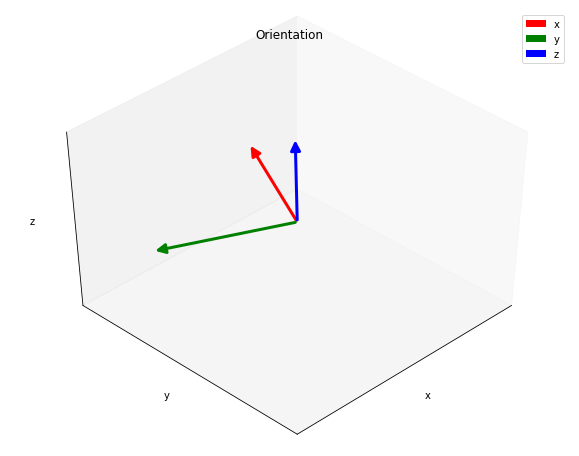

In [20]:
fig = plt.figure(figsize=(10,8), facecolor='white', frameon=False)

# Convert from quaternion (w, x, y, z) to rotation matrix
x,y,z,w = orientation
quaternion = np.array([w,x,y,z])
R = quat2mat(quaternion)

# Apply the rotation to the axis vectors (pointing in Y-axis)
directions = np.eye(3) # x, y, z as column vectors
vectors = np.dot(R, directions)
assert np.allclose(np.linalg.norm(vectors, 2, axis=0), np.ones((3,)), atol=1e-6)

ax = fig.gca(projection='3d')
ax.set_title('Orientation')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
ax.set_zticks([])
ax.view_init(elev=45.0, azim=45.0)
ax.axis([-1.0, 1.0, -1.0, 1.0])
ax.set_zlim(-1.0, 1.0)

# Create arrows
arrows = []
labels = ['x', 'y', 'z']
colors = ['r', 'g', 'b']
for i in range(3):
    x,y,z = vectors[:,i]
    arrow = Arrow3D([0.0, x], [0.0, y], [0.0, z], mutation_scale=20, 
                    lw=3, arrowstyle="-|>", color=colors[i], label=labels[i])
    arrows.append(arrow)
    ax.add_artist(arrow)
    
proxies = [plt.Rectangle((0, 0), 1, 1, fc=c) for c in colors]
legend = ax.legend(proxies, labels, loc='upper right')

if saveFigures:
    fig.savefig('imu-orientation.eps', dpi=300, bbox_inches='tight')

## Odometry: orientation
___

Load orientation data and select a single frame

In [21]:
data, clock, _ = dataset.getData('orientation', 'odometry')

# NOTE: only show the frames at time 200.0 sec
frameTime = 200.0
frameIndex = np.argmin(np.abs(clock - frameTime))

orientation = data[frameIndex,:]

Visualize orientation data

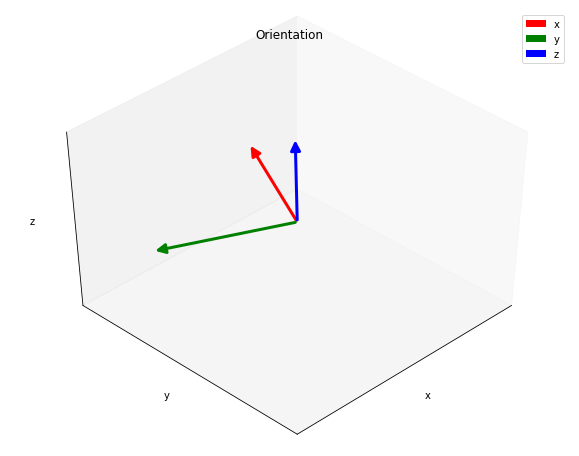

In [22]:
fig = plt.figure(figsize=(10,8), facecolor='white', frameon=False)

# Convert from quaternion (w, x, y, z) to rotation matrix
x,y,z,w = orientation
quaternion = np.array([w,x,y,z])
R = quat2mat(quaternion)

# Apply the rotation to the axis vectors (pointing in Y-axis)
directions = np.eye(3) # x, y, z as column vectors
vectors = np.dot(R, directions)
assert np.allclose(np.linalg.norm(vectors, 2, axis=0), np.ones((3,)), atol=1e-6)

ax = fig.gca(projection='3d')
ax.set_title('Orientation')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
ax.set_zticks([])
ax.view_init(elev=45.0, azim=45.0)
ax.axis([-1.0, 1.0, -1.0, 1.0])
ax.set_zlim(-1.0, 1.0)

# Create arrows
arrows = []
labels = ['x', 'y', 'z']
colors = ['r', 'g', 'b']
for i in range(3):
    x,y,z = vectors[:,i]
    arrow = Arrow3D([0.0, x], [0.0, y], [0.0, z], mutation_scale=20, 
                    lw=3, arrowstyle="-|>", color=colors[i], label=labels[i])
    arrows.append(arrow)
    ax.add_artist(arrow)
    
proxies = [plt.Rectangle((0, 0), 1, 1, fc=c) for c in colors]
legend = ax.legend(proxies, labels, loc='upper right')

if saveFigures:
    fig.savefig('odometry-orientation.eps', dpi=300, bbox_inches='tight')

## Odometry: position
___

Load data and plot 2D position

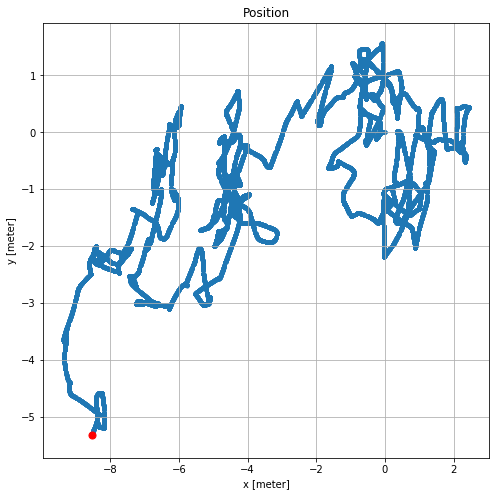

In [23]:
data, _, _ = dataset.getData('position', 'odometry')
x = data[:,0]
y = data[:,1]

fig = plt.figure(figsize=(8,8), facecolor='white', frameon=False)

plt.subplot(111)
scatPast = plt.scatter(x, y, s=10)
scatCur = plt.scatter(x[-1], y[-1], c=[1.0,0.0,0.0], s=50)

plt.grid(True)
plt.title('Position')
plt.xlabel("x [meter]")
plt.ylabel("y [meter]")

if saveFigures:
    fig.savefig('odometry-position.eps', dpi=300, bbox_inches='tight')

Load data and plot angular velocity

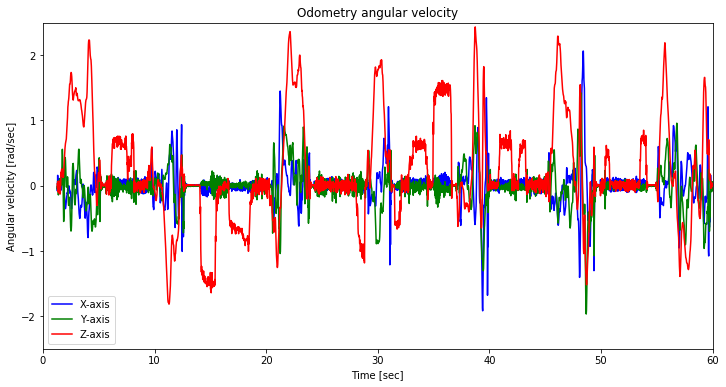

In [24]:
data, clock, _ = dataset.getData('angular_velocity', 'odometry')
angularVelXData = data[:,0] # X-axis
angularVelYData = data[:,1] # Y-axis
angularVelZData = data[:,2] # Z-axis

fig = plt.figure(figsize=(12,6), facecolor='white')

# NOTE: only show the first 60 seconds
xlim = [0, 60]

plt.subplot(111)
plt.title('Odometry angular velocity')
plt.plot(clock, angularVelXData, c='b', label='X-axis')
plt.plot(clock, angularVelYData, c='g', label='Y-axis')
plt.plot(clock, angularVelZData, c='r', label='Z-axis')
plt.xlabel('Time [sec]')
plt.ylabel('Angular velocity [rad/sec]')
plt.xlim(xlim)
plt.ylim([-2.5, 2.5])
plt.legend()

if saveFigures:
    fig.savefig('odometry-angular-velocity.eps', dpi=300, bbox_inches='tight')

Load data and plot linear velocity

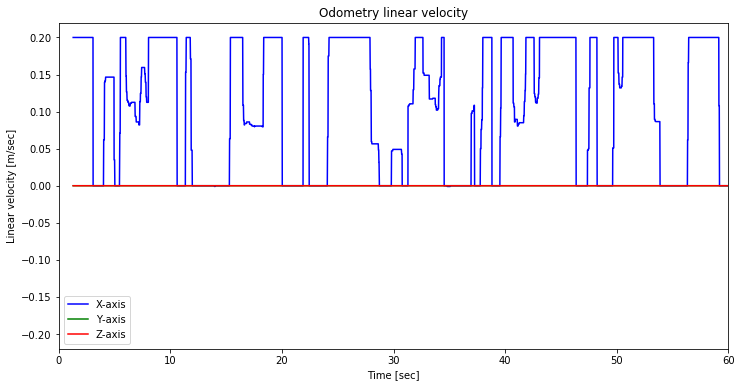

In [25]:
data, clock, _ = dataset.getData('linear_velocity', 'odometry')
linearVelXData = data[:,0] # X-axis
linearVelYData = data[:,1] # Y-axis
linearVelZData = data[:,2] # Z-axis

fig = plt.figure(figsize=(12,6), facecolor='white')

# NOTE: only show the first 60 seconds
xlim = [0, 60]

plt.subplot(111)
plt.title('Odometry linear velocity')
plt.plot(clock, linearVelXData, c='b', label='X-axis')
plt.plot(clock, linearVelYData, c='g', label='Y-axis')
plt.plot(clock, linearVelZData, c='r', label='Z-axis')
plt.xlabel('Time [sec]')
plt.ylabel('Linear velocity [m/sec]')
plt.xlim(xlim)
plt.legend()

if saveFigures:
    fig.savefig('odometry-linear-velocity.eps', dpi=300, bbox_inches='tight')

## Temperature
___

Load data and plot temperature

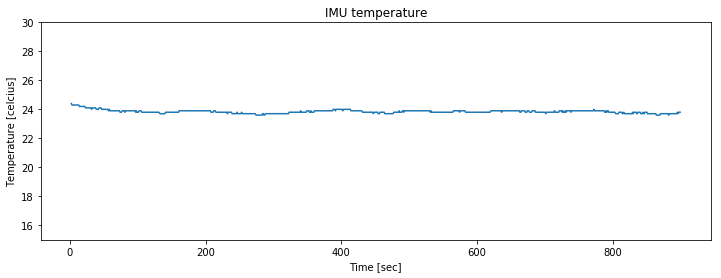

In [26]:
data, clock, _ = dataset.getData('temperature', 'imu')

fig = plt.figure(figsize=(12,4), facecolor='white')

plt.subplot(111)
plt.plot(clock, data)
plt.title('IMU temperature')
plt.xlabel("Time [sec]")
plt.ylabel("Temperature [celcius]")
plt.ylim([15.0, 30.0])

if saveFigures:
    fig.savefig('imu-temperature.eps', dpi=300, bbox_inches='tight')

## Pressure
___

Load data and plot pressure

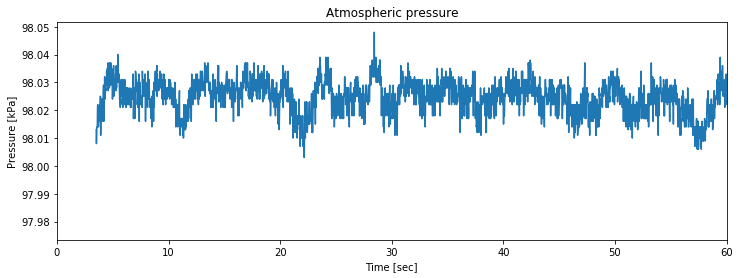

In [27]:
data, clock, _ = dataset.getData('pressure', 'imu')

# Note: convert from Pa to kPa
data = data / 1000.0

fig = plt.figure(figsize=(12,4), facecolor='white')

# NOTE: only show the first 60 seconds
xlim = [0, 60]

plt.subplot(111)
plt.plot(clock, data)
plt.title('Atmospheric pressure')
plt.xlabel("Time [sec]")
plt.ylabel("Pressure [kPa]")
plt.xlim(xlim)

if saveFigures:
    fig.savefig('imu-pressure.eps', dpi=300, bbox_inches='tight')

## Battery
___

Load battery charge data and plot voltage and current

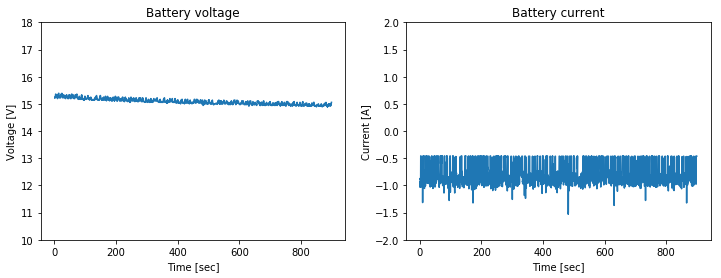

In [28]:
data, clock, _ = dataset.getData('charge', 'battery')
voltage = data[:,0] # Voltage
current = data[:,1] # Current

fig = plt.figure(figsize=(12,4), facecolor='white')

plt.subplot(121)
plt.plot(clock, voltage)
plt.title('Battery voltage')
plt.xlabel("Time [sec]")
plt.ylabel("Voltage [V]")
plt.ylim([10.0, 18.0])

plt.subplot(122)
plt.plot(clock, current)
plt.title('Battery current')
plt.xlabel("Time [sec]")
plt.ylabel("Current [A]")
plt.ylim([-2.0, 2.0])

if saveFigures:
    fig.savefig('battery-charge.eps', dpi=300, bbox_inches='tight')

Load battery capacity data and plot remaining capacity and percentage

Battery capacity estimated at 2.70 Ah


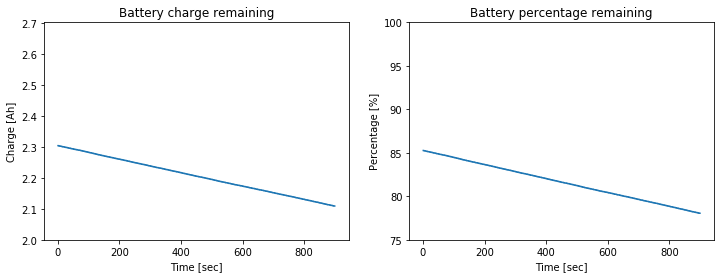

In [29]:
data, clock, _ = dataset.getData('charge', 'battery')
charge = data[:,2]         # Charge remaining
capacity = data[:,3]       # Capacity (estimated)
percentage  = data[:,4]    # Percentage remaining

print('Battery capacity estimated at %0.2f Ah' % (np.mean(capacity)))

fig = plt.figure(figsize=(12,4), facecolor='white')

plt.subplot(121)
plt.plot(clock, charge)
plt.title('Battery charge remaining')
plt.xlabel("Time [sec]")
plt.ylabel("Charge [Ah]")
plt.ylim([2.0, np.max(capacity)])

plt.subplot(122)
plt.plot(clock, percentage * 100.0)
plt.title('Battery percentage remaining')
plt.xlabel("Time [sec]")
plt.ylabel("Percentage [%]")
plt.ylim([75.0, 100.0])

if saveFigures:
    fig.savefig('battery-capacity.eps', dpi=300, bbox_inches='tight')

## Collision: Infrared Rangers and Contact Switches
___

Load infrared rangers data and plot

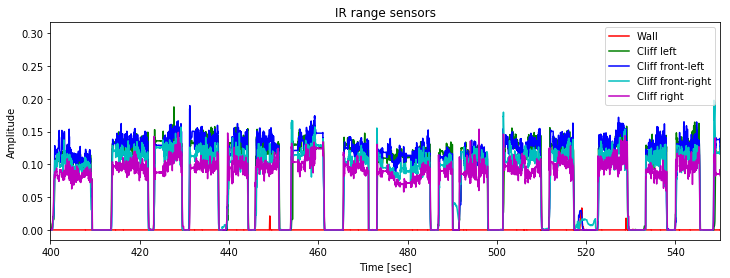

In [30]:
data, clock, _ = dataset.getData('range', 'collision')

wall = data[:,0]
cliffLeft = data[:,1]
cliffFrontLeft = data[:,2]
cliffFrontRight = data[:,3] 
cliffRight = data[:,4] 

fig = plt.figure(figsize=(12,4), facecolor='white')

plt.subplot(111)
plt.plot(clock, wall, '-r', label='Wall')
plt.plot(clock, cliffLeft, '-g', label='Cliff left')
plt.plot(clock, cliffFrontLeft, '-b', label='Cliff front-left')
plt.plot(clock, cliffFrontRight, '-c', label='Cliff front-right')
plt.plot(clock, cliffRight, '-m', label='Cliff right')
plt.title('IR range sensors')
plt.xlabel("Time [sec]")
plt.ylabel("Amplitude")
plt.legend(loc='upper right')
plt.xlim([400, 550])

if saveFigures:
    fig.savefig('collision-range.eps', dpi=300, bbox_inches='tight')

Load contact switches data and plot bumper and wall-related sensors

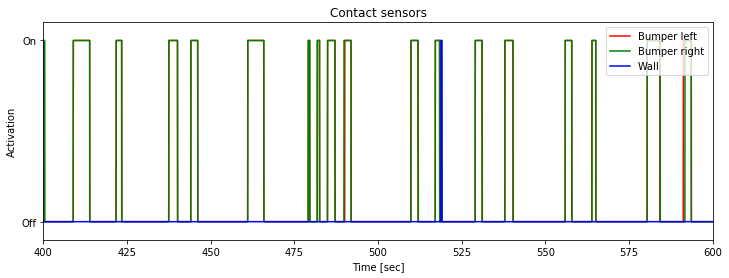

In [31]:
data, clock, _ = dataset.getData('switch', 'collision')

bumperLeft = data[:,0]
bumperRight = data[:,1]
wall = data[:,9]

fig = plt.figure(figsize=(12,4), facecolor='white')

plt.subplot(111)
plt.plot(clock, bumperLeft, '-r', label='Bumper left')
plt.plot(clock, bumperRight, '-g', label='Bumper right')
plt.plot(clock, wall, '-b', label='Wall')
plt.title('Contact sensors')
plt.xlabel("Time [sec]")
plt.ylabel("Activation")
plt.legend(loc='upper right')
plt.xlim([400, 600])
plt.ylim([-0.1, 1.1])
plt.yticks([0.0, 1.0], ['Off', 'On'])

if saveFigures:
    fig.savefig('collision-bumper.eps', dpi=300, bbox_inches='tight')

Load contact switches data and plot cliff sensors

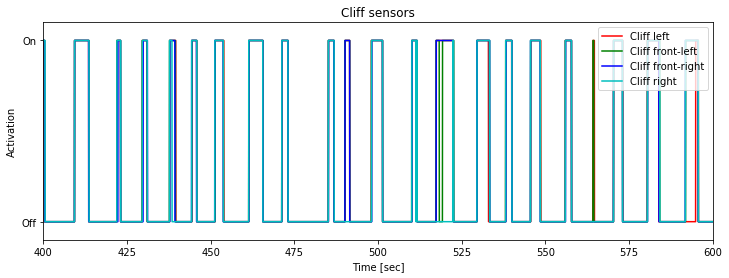

In [32]:
data, clock, _ = dataset.getData('switch', 'collision')

cliffLeft = data[:,5]
cliffFrontLeft = data[:,6]
cliffFrontRight = data[:,7] 
cliffRight = data[:,8] 

fig = plt.figure(figsize=(12,4), facecolor='white')

plt.subplot(111)
plt.plot(clock, cliffLeft, '-r', label='Cliff left')
plt.plot(clock, cliffFrontLeft, '-g', label='Cliff front-left')
plt.plot(clock, cliffRight, '-b', label='Cliff front-right')
plt.plot(clock, cliffFrontRight, '-c', label='Cliff right')
plt.title('Cliff sensors')
plt.xlabel("Time [sec]")
plt.ylabel("Activation")
plt.legend(loc='upper right')
plt.xlim([400, 600])
plt.ylim([-0.1, 1.1])
plt.yticks([0.0, 1.0], ['Off', 'On'])

if saveFigures:
    fig.savefig('collision-cliff.eps', dpi=300, bbox_inches='tight')

Load contact switches data and plot wheel-drop sensors

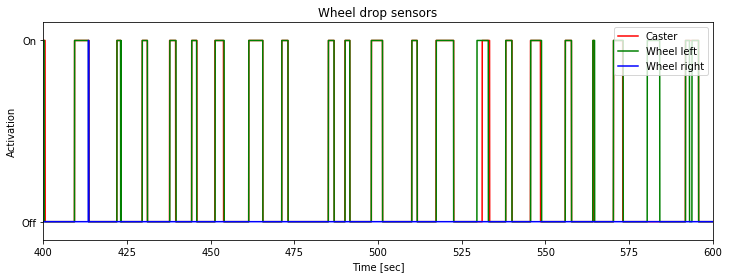

In [33]:
data, clock, _ = dataset.getData('switch', 'collision')

caster = data[:,2]
wheelLeft = data[:,3]
wheelRight = data[:,4]

fig = plt.figure(figsize=(12,4), facecolor='white')

plt.subplot(111)
plt.plot(clock, caster, '-r', label='Caster')
plt.plot(clock, wheelLeft, '-g', label='Wheel left')
plt.plot(clock, wheelRight, '-b', label='Wheel right')
plt.title('Wheel drop sensors')
plt.xlabel("Time [sec]")
plt.ylabel("Activation")
plt.legend(loc='upper right')
plt.xlim([400, 600])
plt.ylim([-0.1, 1.1])
plt.yticks([0.0, 1.0], ['Off', 'On'])

if saveFigures:
    fig.savefig('collision-wheel-drop.eps', dpi=300, bbox_inches='tight')

## Optical flow
___

Load left and right optical flow data

In [34]:
ldata, lclock, _ = dataset.getData('left', 'optical_flow')
rdata, rclock, _ = dataset.getData('right', 'optical_flow')

Select a single frame for each camera

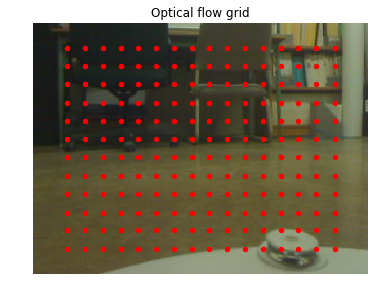

In [35]:
# NOTE: only show the frames at time 100.0 sec
frameTime = 100.0
lframeIndex = np.argmin(np.abs(lclock - frameTime))
rframeIndex = np.argmin(np.abs(rclock - frameTime))

lflow = ldata[lframeIndex,:,:,:]
rflow = rdata[rframeIndex,:,:,:]

lflow[0,0,:]  # Corresponds to the bottom-left corner of the image
lflow[-1,0,:] # Corresponds to the top-left corner of the image
lflow[0,-1,:] # Corresponds to the bottom-right corner of the image
lflow[-1,-1,:]# Corresponds to the top-right corner of the image

# NOTE: hardcoded image size and border used to compute optical flow
ih, iw = 240, 320
border = 0.1
h,w = lflow.shape[:2]
y, x = np.meshgrid(np.linspace(border*ih, (1.0-border)*ih, h, dtype=np.int),
                   np.linspace(border*iw, (1.0-border)*iw, w, dtype=np.int),
                   indexing='ij')

fig = plt.figure(figsize=(6,6), facecolor='white', frameon=False)

plt.subplot(111)
plt.imshow(imgLeft)
plt.scatter(x, y, c=[1.0,0.0,0.0], s=20)
plt.axis('off')
plt.title('Optical flow grid')

if saveFigures:
    fig.savefig('optical-flow-grid.eps', dpi=300, bbox_inches='tight')

Plot left and right optical flow data

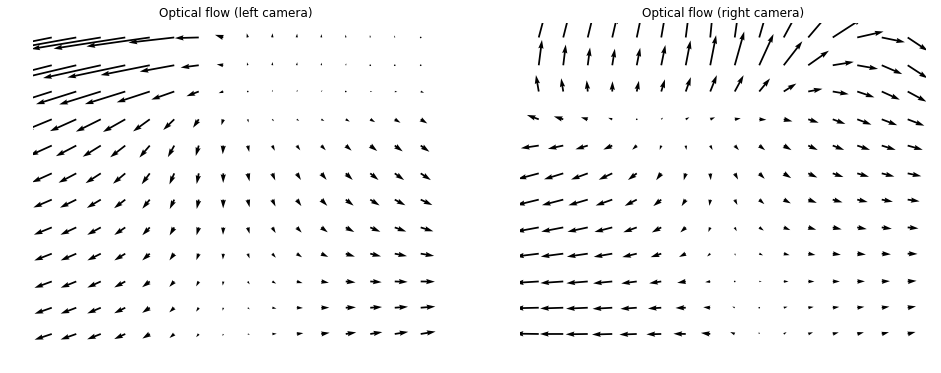

In [36]:
# NOTE: hardcoded image size and border used to compute optical flow
ih, iw = 240, 320
border = 0.1
h,w = lflow.shape[:2]
y, x = np.meshgrid(np.linspace(border*ih, (1.0-border)*ih, h, dtype=np.int),
                   np.linspace(border*iw, (1.0-border)*iw, w, dtype=np.int),
                   indexing='ij')

fig = plt.figure(figsize=(16,6), facecolor='white', frameon=False)

# Left channel
plt.subplot(121)
plt.title('Optical flow (left camera)')
plt.quiver(x, y, lflow[:,:,0], -lflow[:,:,1], 
           edgecolor='k', scale=1, angles='xy', scale_units='xy')
plt.axis('off')

# Right channel
plt.subplot(122)
plt.title('Optical flow (right camera)')
plt.quiver(x, y, rflow[:,:,0], -rflow[:,:,1], 
           edgecolor='k', scale=1, angles='xy', scale_units='xy')
plt.axis('off')

if saveFigures:
    fig.savefig('optical-flow.eps', dpi=300, bbox_inches='tight')